#  Car model recognition
Training File --> Google colab



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Colab_Notebooks/ds-predictive-modelling-project-4-main/cars_data.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04381.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06590.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 200

### Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

tf.random.set_seed(42) 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os

plt.rcParams['font.sans-serif'].insert(0, "Inter") 
plt.rcParams['font.size'] = 12 

### Directories of the input and output



Part I – Data Collection and Preparation

I used Stanford data set which contained 16,185 images of 196 classes of cars. Because the training would take too I dropped 105 models which left me with 91 classes of cars to train.

In [3]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

train_dir = '/content/drive/MyDrive/Colab_Notebooks/ds-predictive-modelling-project-4-main/car_data/car_data/train'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/ds-predictive-modelling-project-4-main/car_data/car_data/test'
checkpoint_dir = '/content/drive/MyDrive/Colab__Notebooks/ds-predictive-modelling-project-4-main/model_cars_finetuned_new_b:128'


class_list = os.listdir(train_dir)
num_classes = len(class_list)
print(len(class_list)) 
# 91 different classes
for models in class_list:
    print(models.title())

91
Acura Rl Sedan 2012
Acura Tl Type-S 2008
Acura Tsx Sedan 2012
Audi S4 Sedan 2012
Acura Zdx Hatchback 2012
Aston Martin Virage Convertible 2012
Audi S4 Sedan 2007
Audi Tt Rs Coupe 2012
Bmw M3 Coupe 2012
Audi V8 Sedan 1994
Bentley Continental Gt Coupe 2012
Bmw Activehybrid 5 Sedan 2012
Bmw X5 Suv 2007
Bmw X3 Suv 2012
Cadillac Escalade Ext Crew Cab 2007
Chevrolet Camaro Convertible 2012
Cadillac Cts-V Sedan 2012
Bugatti Veyron 16.4 Coupe 2009
Chevrolet Cobalt Ss 2010
Buick Enclave Suv 2012
Chevrolet Corvette Zr1 2012
Chevrolet Silverado 2500Hd Regular Cab 2012
Chevrolet Silverado 1500 Regular Cab 2012
Chevrolet Monte Carlo Coupe 2007
Chevrolet Express Cargo Van 2007
Dodge Durango Suv 2007
Chevrolet Sonic Sedan 2012
Chevrolet Tahoe Hybrid Suv 2012
Dodge Dakota Club Cab 2007
Dodge Durango Suv 2012
Dodge Charger Srt-8 2009
Chrysler Sebring Convertible 2010
Chrysler 300 Srt-8 2010
Dodge Caliber Wagon 2007
Dodge Caliber Wagon 2012
Chevrolet Trailblazer Ss 2009
Ferrari California Convertible

### Data Augmentation

To transform the data I used data augmentation object called ImageDataGenerator. The data is augmented to use as input for the `ResNet50` base model.  
The train validation split of 80-20 was used in the model

There's 32 pictures in both train and test folders for each car model before augmentation

In [4]:
# We use the ImageDataGeneration to augment the data and do the validation split
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    brightness_range=[0.4,1.5],
    zoom_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2, 
    height_shift_range=0.2
)
# The flow_from_directory() method allows you to read the images directly
#  from the directory and augment them while the neural network model is learning on the training data.
# The method expects that images belonging to different classes are present in different folders but are
#  inside the same parent folder. 
# We can prepare the training images now
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='training',
    color_mode="rgb",
    class_mode='categorical'
    
)

num_train_images = len(train_generator.filepaths)

# We prepare the validation images with the same method
val_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    color_mode="rgb",
    class_mode='categorical'
)

num_val_images = len(val_generator.filepaths)

Found 3035 images belonging to 91 classes.
Found 707 images belonging to 91 classes.


### Loading the base model
ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer
vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough
with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully.
Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing
gradients. 
#### Base model


Using a base model gives us better result because the base model is already pre-trained to recognize objects and classify them. This gave much better results.
The final layer was not included since I did not want to predicnt 1000 classes of the pretrained model. The goal is to predict 91 classes of cars.



In [5]:
base_model = ResNet50(
    weights='imagenet',
    # don't include the last layer
    include_top=False, 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

94781440/94765736 [==============================] - 0s 0us/step
Number of layers in the base model:  175


### Fine tuning the model
We unfreeze all of the last 100 layers of the model. Then we add a few layers of our own. And finally, we add a Dense layer with 15 units and a Softmax activation at the end to predict our 91 car classes.

In [7]:
# unfreezing the last 100 layers
fine_tune_at = -100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# Add the layers from the base model
x = base_model.output

# Add pooling layers to reduce the dimensions (width and height) of the feature map
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

# Add fully-connected layers
x = Dense(1024, activation='relu')(x) 
# only 70% of neurons are connected to next layer
x = Dropout(0.3)(x) 
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.3)(x)

x = Dense(1024, activation='relu')(x) 
x = Dropout(0.3)(x)

# Final layer: Softmax activation (because it's a multiclass problem)
x = Dense(num_classes, name='dense_logits')(x)
outputs = Activation('softmax', dtype='float32', name='predictions')(x) 

model = Model(
    inputs=base_model.input,
    outputs=outputs
)

### Compiling the model

In [8]:

# Learning rate of 0.0001 was the most optimal among the others 
# based on trial and error
# We use categorical crossentropy since it's a multiclass problem
adam = Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(adam, loss=loss, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Callbacks
ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
It allows us to automatically save our model after each epoch *if and only if* the minimum validation loss (`val_loss`) has decreased.

`EarlyStopping` answers the question "what's the optimal number of epochs?" by monitoring `val_loss`, and stopping the training if there are more than $n$ consecutive epochs without improvement. It also then reverts the weights back to the best value, rolling back any overfitting since then. This allows us to specify an arbitrarily large number of epochs, knowing that training will stop at the optimal moment long before then.

In [9]:
output_path = os.path.join(checkpoint_dir, "model_removed_new-{epoch:03d}-{val_accuracy:.4f}.hdf5")

checkpoint = ModelCheckpoint(
    # We create a path where the model will be stored and saved
    filepath=output_path,
    # should keep decreasing; except for slight jitter, if it increases it's sign of overfitting
    monitor='val_loss', 
    mode='min',
    verbose=True,
    save_best_only=True,
    save_weights_only=False,
    save_frequency='epoch'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=True,
    # Stop training if you don't see improvement ofter 8 epochs
    
    patience=8, 
    restore_best_weights=True
)

### Fitting the model

I trained the model on various values of hyperparameters
such as different learning rates, batches, early stopping patience, and so on. In the end I got the best
accuracy with the batch of 64 and learning rate of 0.0001. I also added and removed layers from the
model to see if it changed anything. Nevertheless, the model presented below had the best results.
In the end the model has been fitted with the data. The accuracy in the last epoch of the training was
around 90%. The model has stopped training on 23rd epoch.

In [10]:
history = model.fit(
    train_generator,
    # This number is random since the model will stop training due to callbacks
    epochs=100, 
    steps_per_epoch=num_train_images // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping],
    validation_data=val_generator,
    validation_steps=num_val_images // BATCH_SIZE
)

Epoch 1/100
 2/23 [=>............................] - ETA: 30:42 - loss: 4.8003 - accuracy: 0.0156

KeyboardInterrupt: ignored

### Metrics: plotting the validation and training loss

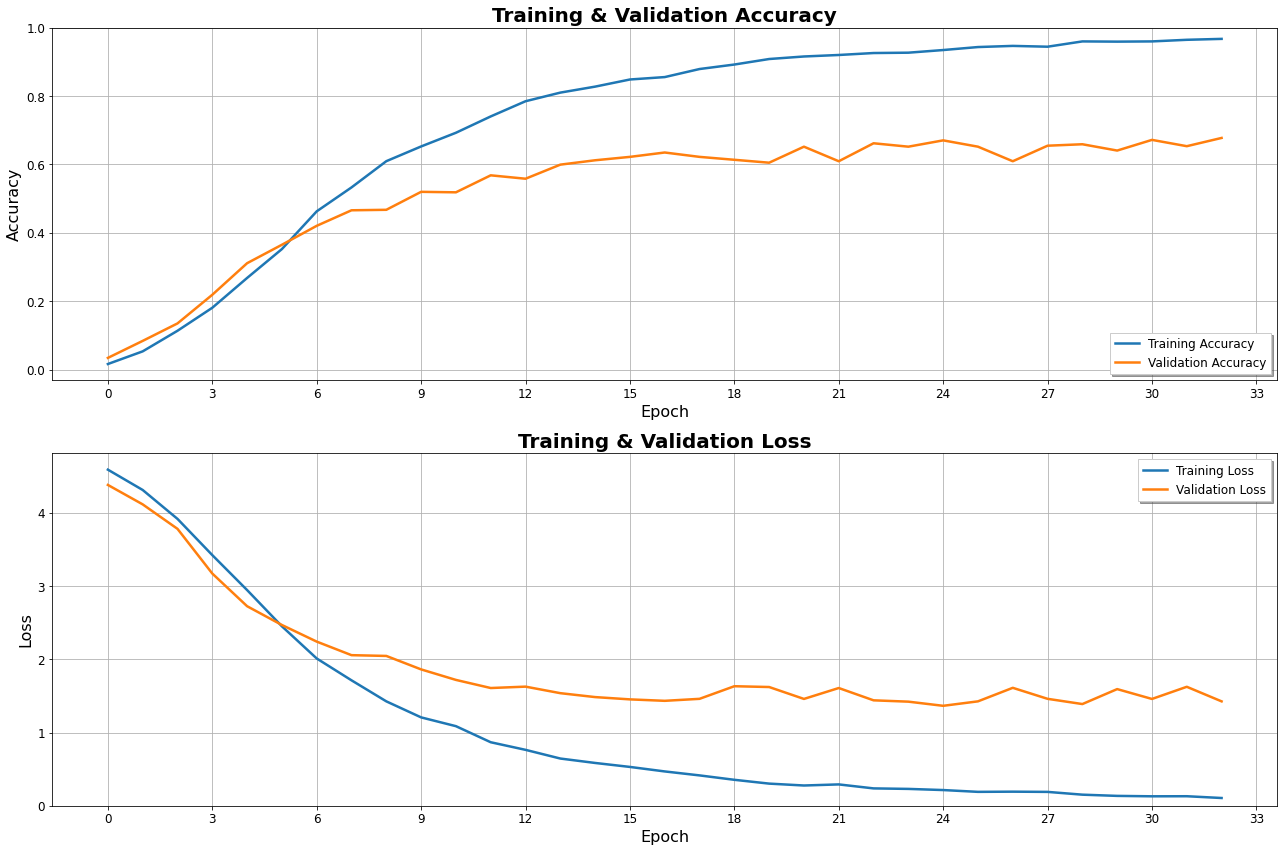

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

for i, (ax, metric), in enumerate(zip(axes.flat, ['accuracy', 'loss'])):
    ax.plot(history.history[f'{metric}'], label=f"Training {metric}".title(), linewidth=2.5)
    ax.plot(history.history[f'val_{metric}'], label=f"Validation {metric}".title(), linewidth=2.5)
    ax.legend(loc=['lower right', 'upper right'][i], fancybox=False, shadow=True)
    ax.set_ylim([[ax.get_ylim()[0], 1], [0, ax.get_ylim()[1]]][i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(min_n_ticks=10, integer=True))
    ax.set_xlabel("Epoch", fontsize=16, fontweight='medium')
    ax.set_ylabel(f"{metric}".title(), fontsize=16, fontweight='medium')
    ax.set_title(f"Training & Validation {metric}".title(), fontsize=20, fontweight='semibold')
    ax.grid()
    ax.set_axisbelow(True)

fig.tight_layout()
plt.show()

### augmenting and predicting the test dataset

In [28]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, shuffle=False)

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator, verbose=True), axis=-1)

Found 3692 images belonging to 91 classes.
29/29 [==============================] - 3022s 108s/step


#### Classification report

                                                 precision    recall  f1-score   support

                            Acura Rl Sedan 2012       0.68      0.59      0.63        32
                           Acura Tl Type-S 2008       0.54      0.64      0.59        42
                           Acura Tsx Sedan 2012       1.00      0.57      0.73        40
                             Audi S4 Sedan 2012       0.87      0.51      0.65        39
                       Acura Zdx Hatchback 2012       0.69      0.67      0.68        33
           Aston Martin Virage Convertible 2012       0.45      0.67      0.54        45
                             Audi S4 Sedan 2007       0.31      0.31      0.31        39
                          Audi Tt Rs Coupe 2012       0.68      0.69      0.68        39
                              Bmw M3 Coupe 2012       0.90      0.44      0.59        43
                             Audi V8 Sedan 1994       0.61      0.82      0.70        34
              Bentle

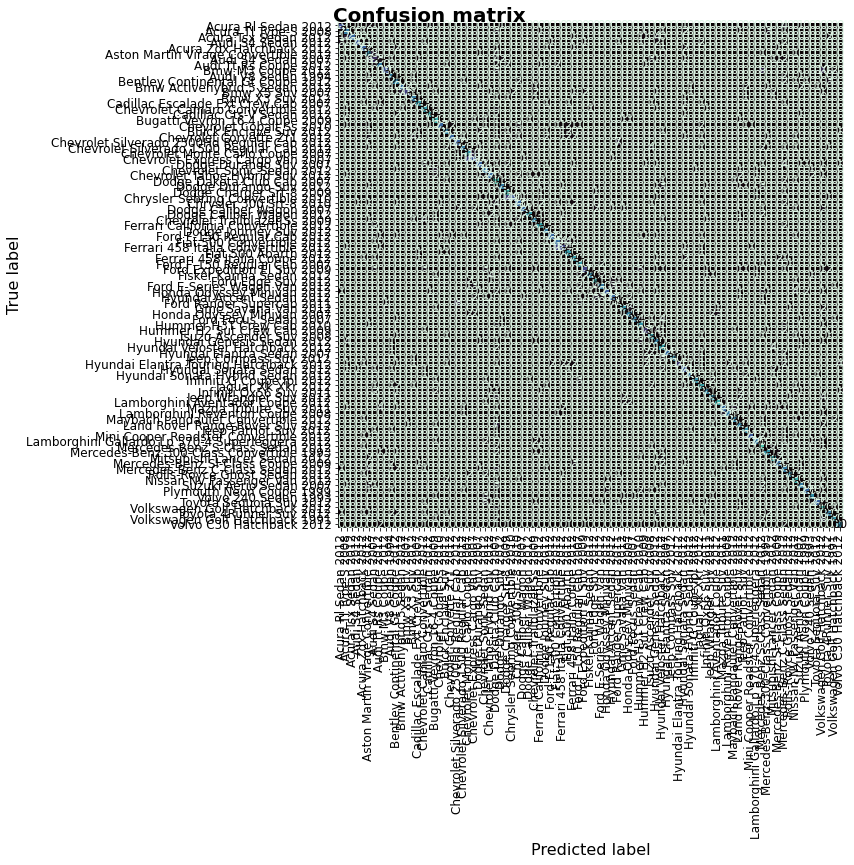

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from seaborn import color_palette

print(
    classification_report(
        y_true=y_true,
        y_pred=y_pred,
        target_names=[species.title() for species in class_list],
        digits=2,
        zero_division=0
    )
)
